In [101]:
import shutil
import os

import pandas as pd
import collections

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import keras
from keras import layers

!pip install keras-cv --quiet
from keras_cv.layers import AugMix

### Dataset preparation

The dataset contains 2 folders
*   Infected
*   Parasitized
And a total of 27,558 images.
Acknowledgements
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/
And uploaded here, so anybody trying to start working with this dataset can get started immediately, as to download the
dataset from NIH website is quite slow.

1. kaggle automatic download
2. load and split the dataset in train/val (80/20) & getting label names
3. compute dataset statistics
4. dataset standardization
5. training data augmentation

#### Download **Kaggle** *malaria NIH dataset*
You are required to load your personal Kaggle API keys (kaggle.json) into colab, then the NIH dataset will be downloaded directly from Kaggle

In [102]:
! pip install kaggle --quiet

In [80]:
# make a kaggle directory, copy the loaded kaggle API key
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
# change r/w permissions
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [81]:
# download the NIH malaria dataset directly from kaggle
! kaggle datasets download iarunava/cell-images-for-detecting-malaria
# optionally rename, unzip the downloaded dataset
# ! mv cell-images-for-detecting-malaria.zip dataset.zip
! unzip -qq cell-images-for-detecting-malaria.zip
! rm cell-images-for-detecting-malaria.zip

# the dataset contains a duplicated folder, to remove it:
try:
  shutil.rmtree('/content/cell_images/cell_images')
except:
    pass

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
replace cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


#### Loading, splitting the dataset and getting class names

In [82]:
# dataset folder
directory = "./cell_images"

filepath = []
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)

# Concatenate data paths with labels
file_path_series = pd.Series(filepath, name='filepath')
Label_path_series = pd.Series(label, name='label')
df_train = pd.concat([file_path_series, Label_path_series], axis=1)

In [83]:
# splitting the dataset and getting class names
img_height = 128
img_width = 128
batch_size = 32

# training, validation set split
# resizing already handled by TensorFlow
# no need to reshape
training_set = tf.keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,  # 80/20%
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='binary'    # parasitized/uninfected
)

validation_set = tf.keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='binary'
)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [84]:
# getting the class names
classes = training_set.class_names
num_classes = len(classes)
print(f'[0={classes[0]}, 1={classes[1]}]')

[0=Parasitized, 1=Uninfected]


#### Compute some dataset statistics

In [85]:

# calculates how many images there are for each class
def num_img_per_class(dataset):
  class_counts = collections.Counter()
  for _, labels in dataset:
      class_indices = labels.numpy().squeeze().astype(int)  # (batch_size, 1) → (batch_size,)
      class_counts.update(map(int, class_indices))
  return class_counts

# Get counts
train_class_counts = num_img_per_class(training_set)
val_class_counts = num_img_per_class(validation_set)
print('Training set:', train_class_counts)
print('Validation set:', val_class_counts)

Training set: Counter({0: 11070, 1: 10977})
Validation set: Counter({1: 2802, 0: 2709})


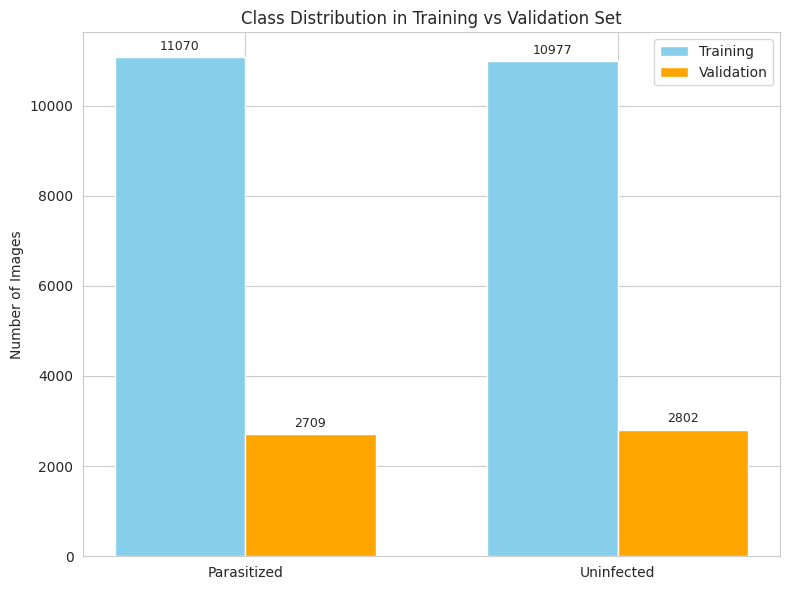

In [86]:
# bar diagram of training and validation classes distribution
labels_map = {0: 'Parasitized', 1: 'Uninfected'}

# Prepare data
x_labels = [labels_map[i] for i in sorted(labels_map.keys())]
x_pos = range(len(x_labels))
train_vals = [train_class_counts[i] for i in sorted(labels_map.keys())]
val_vals = [val_class_counts[i] for i in sorted(labels_map.keys())]

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# Plot bars
bar_width = 0.35
bars1 = plt.bar([i - bar_width/2 for i in x_pos], train_vals, width=bar_width, label='Training', color='skyblue')
bars2 = plt.bar([i + bar_width/2 for i in x_pos], val_vals, width=bar_width, label='Validation', color='orange')

# Add counts on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{height}', ha='center', va='bottom', fontsize=9)

# Final touches
plt.xticks(ticks=x_pos, labels=x_labels)
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training vs Validation Set")
plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-87-39c0b197e97a>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(labels[i].numpy())])


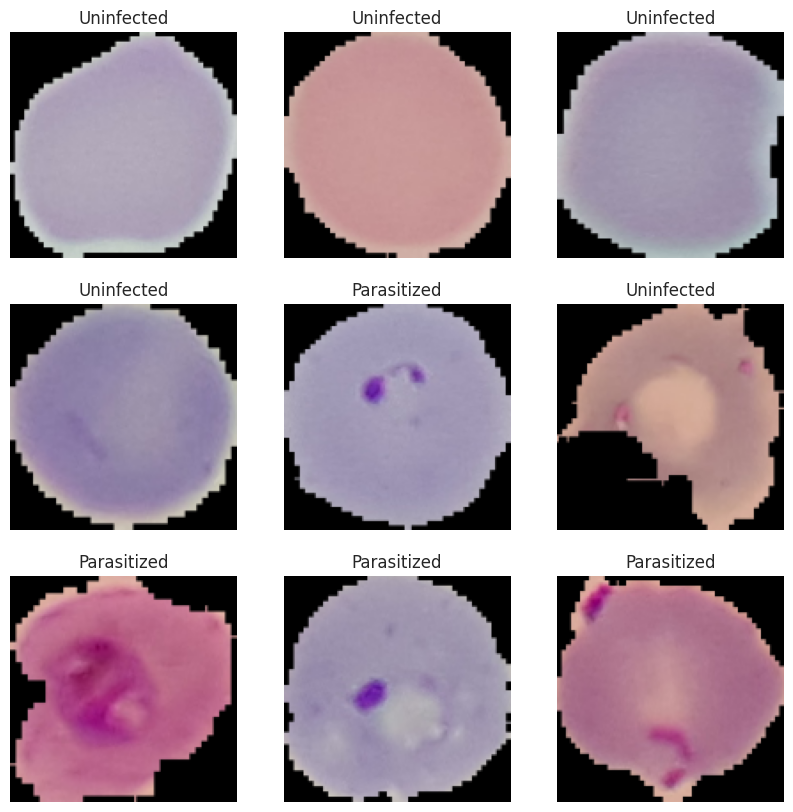

In [87]:
# show the first 9 images of the dataset with the corresponding label
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[int(labels[i].numpy())])
        plt.axis("off")

#### Dataset Augmix + standardization

In [97]:
preprocessing = tf.keras.Sequential([
    AugMix(value_range=(0, 255)),  # see https://arxiv.org/abs/1912.02781
    layers.Rescaling(1./255) # data standardization
])

training_set = training_set.map(lambda x, y: (preprocessing(x), y))

In [100]:
# cache and prefetch for faster training
training_set = training_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)